In [1]:
import pandas as pd

df_master = pd.read_csv(r"C:\Flaskteam_projects\flask_basic\data\master_2015_2022.csv")
df_master.head()

,district,year,grdp,basic_beneficiaries,multicultural_hh,population,divorce,child_facility,child_user,single_parent,birth_cnt,academy_cnt
0,종로구,2015,26762944,3540,1331,11008,276,12,305,480,906,115.1
1,중구,2015,54594969,3916,1156,7818,267,5,169,417,950,72.7
2,용산구,2015,12981760,5696,2110,17997,424,6,163,728,1967,79.2
3,성동구,2015,10728559,7125,1985,21972,563,12,344,1011,2753,107.8
4,광진구,2015,6343138,7332,2586,27104,651,17,496,1511,2951,123.6


모델링 준비 변수선택

In [82]:
import numpy as np
from sklearn.model_selection import train_test_split

# 사용할 최종 변수들
features = [
    "year",
    "single_parent",
    "basic_beneficiaries",
    "multicultural_hh",
    "academy_cnt",
    "grdp",
    "population"

]

target = "child_user"

df = df_master.copy()
X = df[features]
y = df[target]


훈련세트 나누기

In [83]:
train = df[df["year"] <= 2020]
test  = df[df["year"] >= 2021]   # 2021~2022

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

X_train.shape

(150, 7)

Linear Regression

In [84]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

lr = LinearRegression()
lr.fit(X_train, y_train)

pred_lr = lr.predict(X_test)

print("MAE :", mean_absolute_error(y_test, pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred_lr)))
print("R²  :", r2_score(y_test, pred_lr))


MAE : 126.65530475907494
RMSE: 158.52671662810272
R²  : 0.5417029992670379


Linear Regression (distirct 원핫 인코딩)

In [85]:
# district 원핫 인코딩 적용한 데이터 준비
df_ohe = pd.get_dummies(df_master.copy(), columns=["district"], drop_first=False)

# district_ 로 시작하는 컬럼들만 추출
district_ohe_cols = [c for c in df_ohe.columns if c.startswith("district_")]

# 기본 피처
base_features = [
    "year",
    "single_parent",
    "basic_beneficiaries",
    "multicultural_hh",
    "academy_cnt",
    "grdp",
    "population",
]

# 원핫까지 포함한 최종 피처
features_ohe = base_features + district_ohe_cols
target = "child_user"

train_ohe = df_ohe[df_ohe["year"] <= 2020]
test_ohe  = df_ohe[df_ohe["year"] >= 2021]

X_train_ohe = train_ohe[features_ohe]
y_train_ohe = train_ohe[target]

X_test_ohe = test_ohe[features_ohe]
y_test_ohe = test_ohe[target]

print("X_train_ohe:", X_train_ohe.shape)
print("X_test_ohe :", X_test_ohe.shape)

# 선형회귀 학습 (district 원핫 포함)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

lr_ohe = LinearRegression()
lr_ohe.fit(X_train_ohe, y_train_ohe)

pred_lr_ohe = lr_ohe.predict(X_test_ohe)

print("===== Linear Regression (with district One-Hot) =====")
print("MAE :", mean_absolute_error(y_test_ohe, pred_lr_ohe))
print("RMSE:", np.sqrt(mean_squared_error(y_test_ohe, pred_lr_ohe)))
print("R²  :", r2_score(y_test_ohe, pred_lr_ohe))


X_train_ohe: (150, 32)
X_test_ohe : (50, 32)
===== Linear Regression (with district One-Hot) =====
MAE : 75.83299385825849
RMSE: 91.62394720498811
R²  : 0.8469053266084218


RandomForest

In [86]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=42
)

rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)

print("MAE :", mean_absolute_error(y_test, pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred_rf)))
print("R²  :", r2_score(y_test, pred_rf))

MAE : 83.21055999999999
RMSE: 122.86120420181466
R²  : 0.7247219260402264


RandomForest Feature Importance

C:\Users\eldorado\AppData\Local\Temp\ipykernel_9376\2007115009.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi_df, x="importance", y="feature", palette="Blues_r")


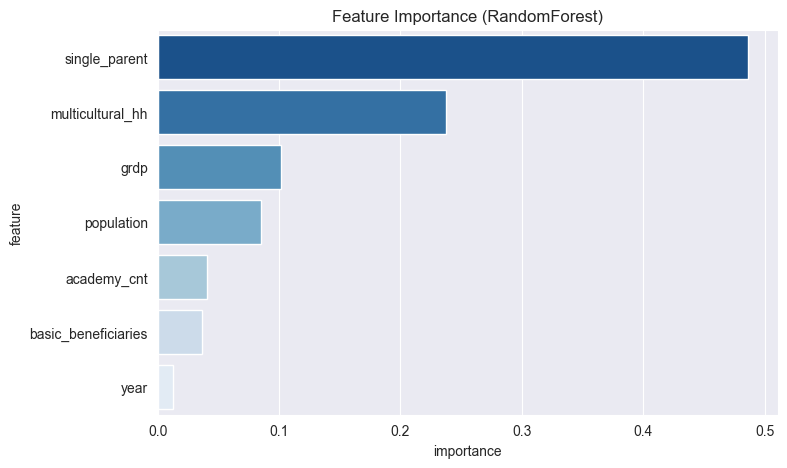

,feature,importance
1,single_parent,0.486476
3,multicultural_hh,0.237441
5,grdp,0.101655
6,population,0.084811
4,academy_cnt,0.040907
2,basic_beneficiaries,0.036429
0,year,0.012280


In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf.feature_importances_
fi_df = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=fi_df, x="importance", y="feature", palette="Blues_r")
plt.title("Feature Importance (RandomForest)")
plt.show()

fi_df


XGBoost

In [88]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

xgb = XGBRegressor(
    n_estimators=600,        # 트리 개수
    max_depth=4,             # 트리 깊이
    learning_rate=0.05,      # 학습률
    subsample=0.9,           # 샘플링 비율
    colsample_bytree=0.8,    # feature 샘플링 비율
    random_state=42
)

xgb.fit(X_train, y_train)

pred_xgb = xgb.predict(X_test)

print("MAE :", mean_absolute_error(y_test, pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred_xgb)))
print("R²  :", r2_score(y_test, pred_xgb))


MAE : 80.66059875488281
RMSE: 118.0002648302113
R²  : 0.7460734844207764


하이퍼 파라미터 튜닝

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)


# Hyperparameter Search Space
param_dist = {
    "n_estimators": [200, 300, 500, 700],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "max_depth": [3, 4, 5, 6],
    "subsample": [0.6, 0.7, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2, 0.3],
    "reg_alpha": [0, 0.01, 0.1, 0.5],
    "reg_lambda": [1, 1.5, 2]
}

# Randomized Search
search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30, # 30번 시도
    scoring='r2',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)

best_xgb = search.best_estimator_
print("Best Parameters:", search.best_params_)

# Evaluate tuned model
pred_xgb = best_xgb.predict(X_test)

print("MAE :", mean_absolute_error(y_test, pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred_xgb)))
print("R²  :", r2_score(y_test, pred_xgb))


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'subsample': 0.7, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}
MAE : 71.44576263427734
RMSE: 98.47595479037003
R²  : 0.8231510519981384


튜닝 후 XGBoost Feature Importance

<Figure size 800x600 with 0 Axes>

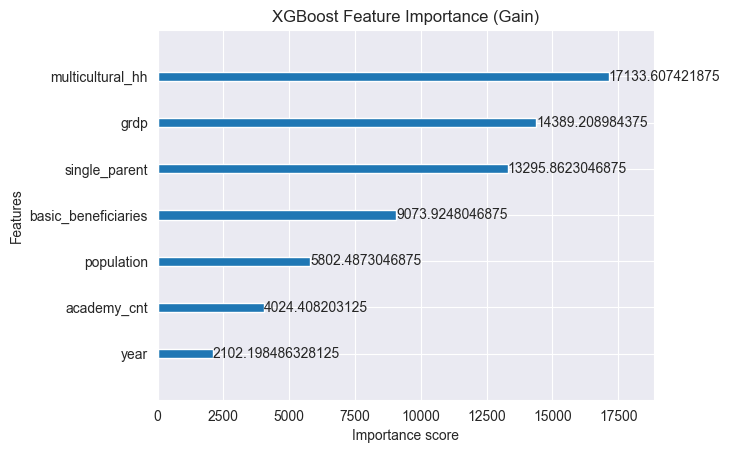

In [90]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plot_importance(best_xgb, importance_type='gain')
plt.title("XGBoost Feature Importance (Gain)")
plt.show()


In [91]:
# 2차 튜닝 Search Space (Local Search)
param_grid_local = {
    'max_depth': [4, 5, 6],
    'learning_rate': [0.03, 0.05, 0.07],
    'n_estimators': [600, 700, 800],
    'subsample': [0.5, 0.6, 0.7],
    'colsample_bytree': [0.5, 0.6, 0.7],
    'gamma': [0.1, 0.3, 0.5],
    'reg_lambda': [1.0, 1.5, 2.0],
    'reg_alpha': [0, 0.1, 0.3]
}

xgb_model_local = XGBRegressor(
    random_state=42,
    tree_method="hist"
)

search_local = RandomizedSearchCV(
    estimator=xgb_model_local,
    param_distributions=param_grid_local,
    n_iter=30,
    scoring='r2',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

search_local.fit(X_train, y_train)

print(search_local.best_params_)

# 최종 모델
best_xgb_local = XGBRegressor(
    **search_local.best_params_,
    random_state=42
)
best_xgb_local.fit(X_train, y_train)

# 성능 평가
pred_local = best_xgb_local.predict(X_test)

print("MAE :", mean_absolute_error(y_test, pred_local))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred_local)))
print("R²  :", r2_score(y_test, pred_local))


Fitting 3 folds for each of 30 candidates, totalling 90 fits
{'subsample': 0.6, 'reg_lambda': 2.0, 'reg_alpha': 0.3, 'n_estimators': 700, 'max_depth': 4, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.7}
MAE : 70.48839569091797
RMSE: 98.53910430953287
R²  : 0.8229241967201233


XGBoost (district 원핫 + log1p)

In [92]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

X_train_ohe = train_ohe[features_ohe]
y_train_ohe = train_ohe[target]
X_test_ohe = test_ohe[features_ohe]
y_test_ohe = test_ohe[target]

print("X_train_ohe:", X_train_ohe.shape)
print("X_test_ohe :", X_test_ohe.shape)
print("feature 개수:", len(features_ohe))

# log1p 타깃으로 학습
y_train_ohe_log = np.log1p(y_train_ohe)

param_grid_local = {
    'max_depth': [4, 5, 6],
    'learning_rate': [0.03, 0.05, 0.07],
    'n_estimators': [600, 700, 800],
    'subsample': [0.5, 0.6, 0.7],
    'colsample_bytree': [0.5, 0.6, 0.7],
    'gamma': [0.1, 0.3, 0.5],
    'reg_lambda': [1.0, 1.5, 2.0],
    'reg_alpha': [0, 0.1, 0.3],
}

xgb_ohe = XGBRegressor(
    random_state=42,
    tree_method="hist"
)

search_ohe = RandomizedSearchCV(
    estimator=xgb_ohe,
    param_distributions=param_grid_local,
    n_iter=30,
    scoring='r2',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

search_ohe.fit(X_train_ohe, y_train_ohe_log)

print("Best Params (OHE + log1p):", search_ohe.best_params_)

# 최종 XGBoost 모델
best_xgb_ohe = XGBRegressor(
    **search_ohe.best_params_,
    random_state=42
)
best_xgb_ohe.fit(X_train_ohe, y_train_ohe_log)

best_xgb_ohe.district_ohe_cols = district_ohe_cols
best_xgb_ohe.base_features = base_features

# 평가: 로그에서 원래 스케일로 되돌려서 성능 확인
pred_log_ohe = best_xgb_ohe.predict(X_test_ohe)
pred_ohe = np.expm1(pred_log_ohe)

print("===== XGBoost (district OHE + log1p) =====")
print("MAE :", mean_absolute_error(y_test_ohe, pred_ohe))
print("RMSE:", np.sqrt(mean_squared_error(y_test_ohe, pred_ohe)))
print("R²  :", r2_score(y_test_ohe, pred_ohe))


X_train_ohe: (150, 32)
X_test_ohe : (50, 32)
feature 개수: 32
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Params (OHE + log1p): {'subsample': 0.6, 'reg_lambda': 2.0, 'reg_alpha': 0, 'n_estimators': 800, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.5}
===== XGBoost (district OHE + log1p) =====
MAE : 70.68213653564453
RMSE: 92.53254811652762
R²  : 0.8438539505004883


2023~2030 예측

In [93]:
df = df_master.copy()

# base_year, last_year, future 기간 설정
base_year = 2015
last_year = 2022
future_start = 2023
future_end = 2030

# 여기서 사용할 feature는 base_features만 성장률 적용 (연속 변수들만)
feature_cols = base_features.copy()  # ["year", "single_parent", ... "population"]

trained_model = best_xgb_ohe  # OHE + log1p

# CAGR 계산 함수
def calc_cagr(series, start_year, end_year):
    v0 = series.loc[start_year]
    v1 = series.loc[end_year]
    if v0 <= 0 or v1 <= 0:
        return 0.0
    return (v1 / v0) ** (1 / (end_year - start_year)) - 1


future_rows = []
districts = df["district"].unique()

for district in districts:
    df_dist = df[df["district"] == district]
    df_period = df_dist[df_dist["year"].between(base_year, last_year)]

    # year 제외한 나머지 base feature만 성장률 계산
    growth_rates = {col: 0.0 for col in feature_cols if col != "year"}

    for col in growth_rates.keys():
        yearly_sum = df_period.groupby("year")[col].sum()

        if base_year not in yearly_sum.index or last_year not in yearly_sum.index:
            continue

        growth_rates[col] = calc_cagr(yearly_sum, base_year, last_year)

    # 기준이 되는 마지막 해(2022)의 값
    base_row = df_dist[df_dist["year"] == last_year].iloc[0]

    for year in range(future_start, future_end + 1):
        years_ahead = year - last_year

        new_row = {"district": district, "year": year}

        for col in growth_rates.keys():
            base_val = base_row[col]
            rate = growth_rates[col]
            new_row[col] = base_val * ((1 + rate) ** years_ahead)

        future_rows.append(new_row)

# 1차: district 컬럼 + 연속 feature만 있는 상태
future_df = pd.DataFrame(future_rows)

# district 원핫 인코딩 적용
future_df_ohe = pd.get_dummies(future_df, columns=["district"], drop_first=False)

# 학습 때 쓰던 district_ohe_cols가 다 있는지 체크, 없으면 0으로 채우기(안전장치)
for col in district_ohe_cols:
    if col not in future_df_ohe.columns:
        future_df_ohe[col] = 0

# 최종 feature 컬럼은 학습 때와 동일하게 features_ohe 사용
X_future = future_df_ohe[features_ohe]

# log 스케일 → 원래 스케일로 되돌리기
pred_future_log = trained_model.predict(X_future)
future_df_ohe["child_user"] = np.expm1(pred_future_log)

# 확인
future_df_ohe.head(10)

,year,single_parent,basic_beneficiaries,multicultural_hh,academy_cnt,grdp,population,district_강남구,district_강동구,district_강북구,...,district_성북구,district_송파구,district_양천구,district_영등포구,district_용산구,district_은평구,district_종로구,district_중구,district_중랑구,child_user
0,2023,267.731708,5487.607259,1157.628422,171.667363,3.553604e+07,8778.070876,False,False,False,...,False,False,False,False,False,False,True,False,False,260.301971
1,2024,248.889818,5796.695558,1137.609138,180.463463,3.681806e+07,8533.170354,False,False,False,...,False,False,False,False,False,False,True,False,False,264.477509
2,2025,231.373945,6123.193189,1117.936054,189.710269,3.814633e+07,8295.102343,False,False,False,...,False,False,False,False,False,False,True,False,False,264.477509
3,2026,215.090770,6468.080730,1098.603184,199.430873,3.952252e+07,8063.676223,False,False,False,...,False,False,False,False,False,False,True,False,False,265.326111
4,2027,199.953539,6832.393987,1079.604644,209.649554,4.094836e+07,7838.706689,False,False,False,...,False,False,False,False,False,False,True,False,False,265.326111
5,2028,185.881606,7217.227110,1060.934653,220.391832,4.242564e+07,7620.013609,False,False,False,...,False,False,False,False,False,False,True,False,False,273.603516
6,2029,172.800000,7623.735876,1042.587528,231.684535,4.395622e+07,7407.421875,False,False,False,...,False,False,False,False,False,False,True,False,False,269.200684
7,2030,160.639025,8053.141160,1024.557687,243.555868,4.554201e+07,7200.761265,False,False,False,...,False,False,False,False,False,False,True,False,False,256.384583
8,2023,330.227785,6419.641671,1353.411728,92.904704,7.486401e+07,6464.550335,False,False,False,...,False,False,False,False,False,False,False,True,False,137.387466
9,2024,320.736441,6828.798539,1380.349138,95.796714,7.787770e+07,6312.750911,False,False,False,...,False,False,False,False,False,False,False,True,False,146.378326


In [94]:
future_df_ohe.to_csv(
    r"C:\Flaskteam_projects\flask_basic\data\predicted_child_user_2023_2030.csv",
    index=False,
    encoding="utf-8-sig"
)

future_df_ohe.head()

,year,single_parent,basic_beneficiaries,multicultural_hh,academy_cnt,grdp,population,district_강남구,district_강동구,district_강북구,...,district_성북구,district_송파구,district_양천구,district_영등포구,district_용산구,district_은평구,district_종로구,district_중구,district_중랑구,child_user
0,2023,267.731708,5487.607259,1157.628422,171.667363,3.553604e+07,8778.070876,False,False,False,...,False,False,False,False,False,False,True,False,False,260.301971
1,2024,248.889818,5796.695558,1137.609138,180.463463,3.681806e+07,8533.170354,False,False,False,...,False,False,False,False,False,False,True,False,False,264.477509
2,2025,231.373945,6123.193189,1117.936054,189.710269,3.814633e+07,8295.102343,False,False,False,...,False,False,False,False,False,False,True,False,False,264.477509
3,2026,215.090770,6468.080730,1098.603184,199.430873,3.952252e+07,8063.676223,False,False,False,...,False,False,False,False,False,False,True,False,False,265.326111
4,2027,199.953539,6832.393987,1079.604644,209.649554,4.094836e+07,7838.706689,False,False,False,...,False,False,False,False,False,False,True,False,False,265.326111
